# Split operator example of use
In this file, one will try to present how we can work with the split operator to simulate the KRAKEN experiment.

In [159]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from scipy.fft import fft, fftfreq
import scipy.sparse.linalg as spla
import scipy.sparse as sparse

In [160]:
# Paramètres
x = np.linspace(-500, 500, 2048)        # in a.u. => in bohr units
dx = x[1] - x[0]
dt = 0.05
t = np.arange(-400, 400, dt)                # also in a.u. => 1au=roughly 24as
N = len(x)
k = np.fft.fftfreq(N, d=dx) * 2 * np.pi

In [161]:
wavelength = 1030  # nm, NOT IN A.U. the conversion is done later
I_wcm2 = 1e14  # Intensity in W/cm^2, NOT IN A.U. the conversion is done later


freq = 3e8 / (wavelength * 1e-9)  # Frequency in Hz, converting nm to m
t_au = 2.418884e-17  # s, constant for conversion to atomic units
omega_au = 2*np.pi*freq*t_au
periode_au = 2*np.pi / omega_au  # Period in atomic units
pulse_duration = 5 * periode_au  # Pulse duration in atomic units
E0 = 5.338e-9 * np.sqrt(I_wcm2)
envelope = lambda t : np.where((t >= -pulse_duration/2) & (t <= pulse_duration/2),
                               np.cos(np.pi * t / pulse_duration)**2, 0)
# envelope = lambda t: 0*t
champE_func = lambda x, t: E0*np.cos(omega_au * t) * envelope(t)
champE = champE_func(x[:, None], t)  # Champ électrique en fonction de x et t

Text(0, 0.5, 'Electric Field (a.u.)')

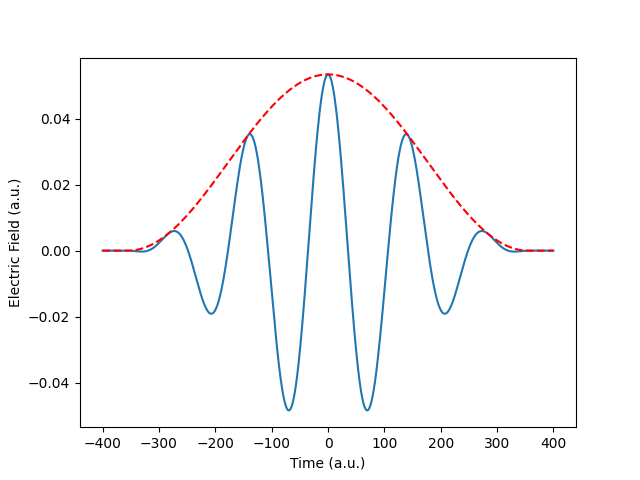

In [162]:
plt.figure()
plt.plot(t, champE)
plt.plot(t, envelope(t) * E0, 'r--', label='Envelope')
plt.xlabel('Time (a.u.)')
plt.ylabel('Electric Field (a.u.)')


In [163]:
# Potentiel
epsilon = 0
V = -1.0 / np.sqrt(x**2 + epsilon)

Text(0, 0.5, 'Potential (a.u.)')

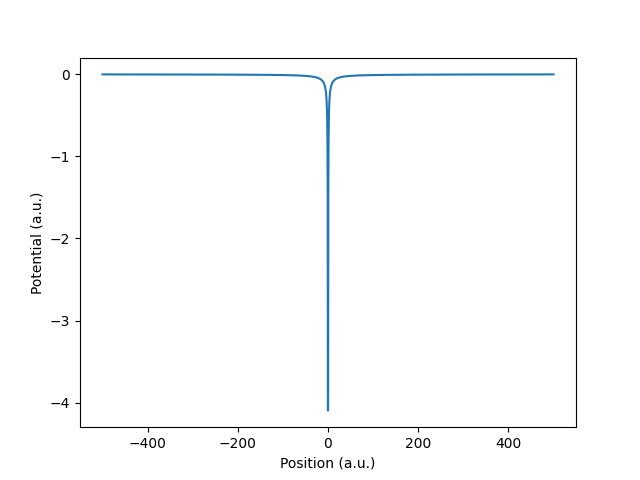

In [164]:
plt.figure()
plt.plot(x, V)
plt.xlabel('Position (a.u.)')
plt.ylabel('Potential (a.u.)')


In [165]:
# Split-operator
def evolve(psi, V, E, dt):
    """
    Evolves the wavefunction psi by one time step using the split-operator method.

    The split-operator method is a numerical technique for solving the time-dependent Schrödinger equation.
    It exploits the fact that the Hamiltonian can be split into kinetic and potential parts, which are applied
    in alternating steps in position and momentum (Fourier) space. This allows efficient and accurate time evolution
    of quantum systems.

    Parameters
    ----------
    psi : np.ndarray
        The current wavefunction (array of complex values).
    V : np.ndarray
        The potential energy as a function of position.
    E : float or np.ndarray
        The electric field value (or array) at the current time step.
    dt : float
        The time step for evolution.

    Returns
    -------
    np.ndarray
        The evolved wavefunction after one time step.

    Principle
    ---------
    The time-evolution operator for a small time step dt is approximated as:
        U(dt) ≈ exp(-i V dt/2) exp(-i T dt) exp(-i V dt/2)
    where T is the kinetic energy operator. The kinetic part is applied in Fourier space,
    while the potential part is applied in position space. An additional phase from the electric field is included.
    """
    A = np.exp(-1j * V * dt / 2)
    B = np.exp(-1j * E * x * dt / 2)
    psi = B * psi
    psi = A * psi
    psi_k = np.fft.fft(psi)
    psi_k *= np.exp(-1j * (k**2) * dt / 2)
    psi = np.fft.ifft(psi_k)
    psi = A * psi
    psi = B * psi
    return psi


def direct_TDSE(psi, V, E, dt):
    """
    Directly solves the time-dependent Schrödinger equation (TDSE) for a wavefunction psi.
    The aim of this function is to not use the evolve function but to directly apply the TDSE
    without splitting the operator.
    

    """
    dpsi_dt = -1j * (-0.5 * np.gradient(np.gradient(psi, dx), dx) + V * psi + E * x * psi)      # BE CAREFUL WE ARE IN A.U.
    # print((dpsi_dt * dt).dtype)
    psi += dpsi_dt * dt
    psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx)
    return psi


def evolve_crank_nikolson(psi, V, E, dt, x):
    Nx = len(x)
    diagonals = [-2*np.ones(Nx), np.ones(Nx-1), np.ones(Nx-1)]
    L = sparse.diags(diagonals, [0, -1, 1]) / dx**2
    H = -0.5 * L + sparse.diags(V, 0) + sparse.diags(E * x, 0)  # Hamiltonian operator in sparse matrix form
    I = sparse.diags(np.ones(Nx), 0)
    A = (I + 1j * dt / 2 * H).tocsc()
    B = (I - 1j * dt / 2 * H).tocsc()
    b = B.dot(psi)
    psi = spla.spsolve(A, b)
    psi /= np.linalg.norm(psi)  # normalisation, in theory not needed but good practice
    return psi


100%|██████████| 16000/16000 [02:31<00:00, 105.43it/s]


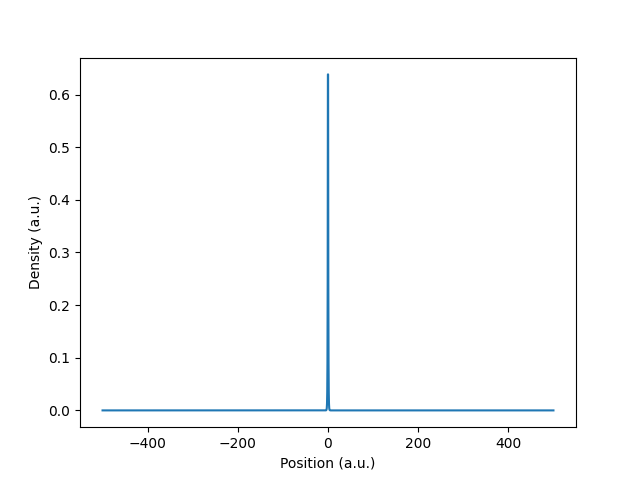

In [166]:
# Initialisation de psi
psi = 1/np.sqrt(np.pi) * np.exp(-np.abs(x))
psi /= np.linalg.norm(psi) * np.sqrt(dx)
psi = np.complex128(psi)  # Convert to complex128 for TDSE
psi_fonda = psi.copy()  # Save the initial state for later use


plt.figure()
plt.plot(x, np.abs(psi)**2, label='Initial Density')
plt.xlabel('Position (a.u.)')
plt.ylabel('Density (a.u.)')



rho_history = []
psi_history = []
# Évolution
for En in tqdm(champE):
    psi = evolve_crank_nikolson(psi, V, En, dt, x)
    rho = np.abs(psi)**2
    rho_history.append(rho)
    psi_history.append(psi.copy())

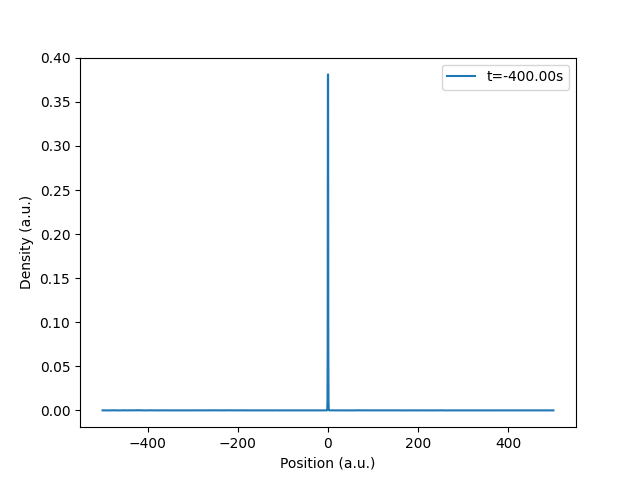

In [167]:
plt.figure()
plt.plot(x, rho, label=f't={t[0]:.2f}s')
plt.xlabel('Position (a.u.)')
plt.ylabel('Density (a.u.)')
plt.legend()
# plt.show()

C:\Users\ma5706ba\AppData\Local\Temp\ipykernel_4436\3657472638.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t, champE/np.max(champE)*250, 'k--', color="red", label='Electric Field (normalized)')


Text(0.5, 1.0, 'Density Evolution')

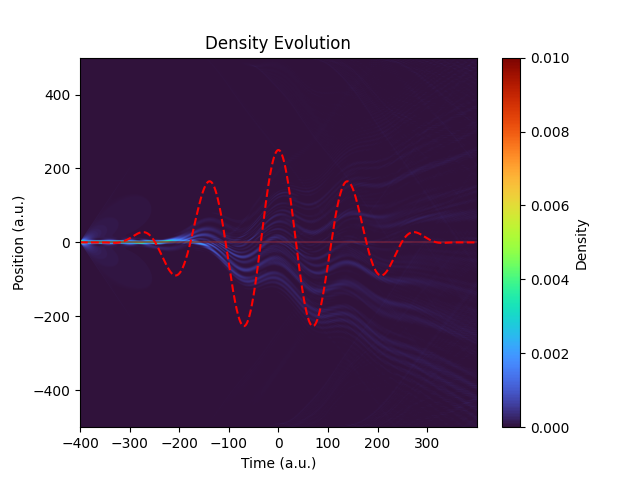

In [168]:
plt.figure()

plt.imshow(np.array(rho_history).T, aspect='auto', extent=[t[0], t[-1], x[0], x[-1]], origin='lower', cmap="turbo")
plt.plot(t, champE/np.max(champE)*250, 'k--', color="red", label='Electric Field (normalized)')
plt.clim(0, 0.01)
plt.colorbar(label='Density')
plt.xlabel('Time (a.u.)')
plt.ylabel('Position (a.u.)')
plt.title('Density Evolution')

In [169]:
def kinetic_energy(psi, dx):
    """
    Compute the kinetic energy expectation value from a wavefunction psi
    using finite differences for the second derivative.
    """
    d2psi_dx2 = np.gradient(np.gradient(psi, dx), dx)
    T = -0.5 * np.sum(np.conj(psi) * d2psi_dx2) * dx
    return T.real  # kinetic energy is a real quantity

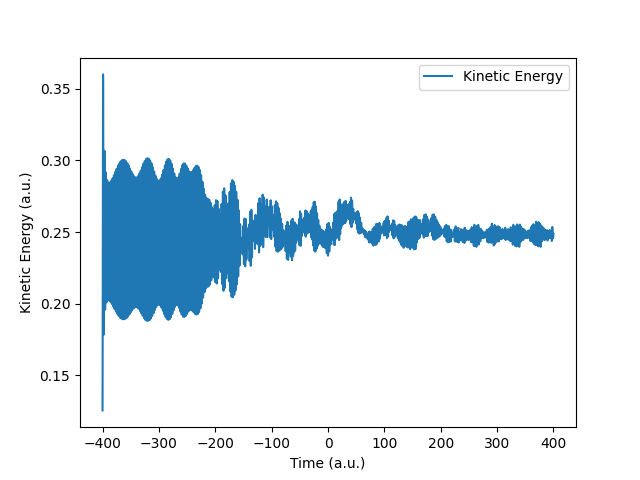

In [170]:
T_history = []
for psi_t in psi_history:
    T = kinetic_energy(psi_t, dx)
    T_history.append(T)
plt.figure()
plt.plot(t, T_history, label='Kinetic Energy')
plt.xlabel('Time (a.u.)')
plt.ylabel('Kinetic Energy (a.u.)')
plt.legend()


## Next step : application to HHG theory

In [ ]:
dipole = []
for i, psi_t in enumerate(psi_history):
    d = np.sum(np.conj(psi_fonda) * x * psi_t).real * dx        # TODO continue here
    dipole.append(d)
dipole = np.array(dipole)

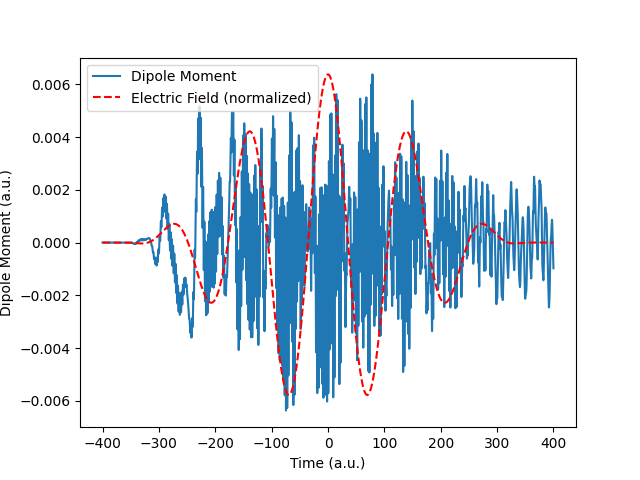

In [172]:
plt.figure()
plt.plot(t, dipole, label='Dipole Moment')
plt.plot(t, champE/np.max(champE) * np.max(dipole), 'r--', label='Electric Field (normalized)')
plt.xlabel('Time (a.u.)')
plt.ylabel('Dipole Moment (a.u.)')
plt.legend()

In [173]:
d2dt = np.gradient(np.gradient(dipole, dt), dt)
E_emis = d2dt
E_emis

array([-1.08473183e-14, -1.35591478e-14, -1.62709774e-14, ...,
       -3.79499376e-04, -2.98315894e-04, -2.02755498e-04], shape=(16000,))

Text(0.5, 1.0, 'Champ électromagnétique émis (∝ d²⟨x⟩/dt²)')

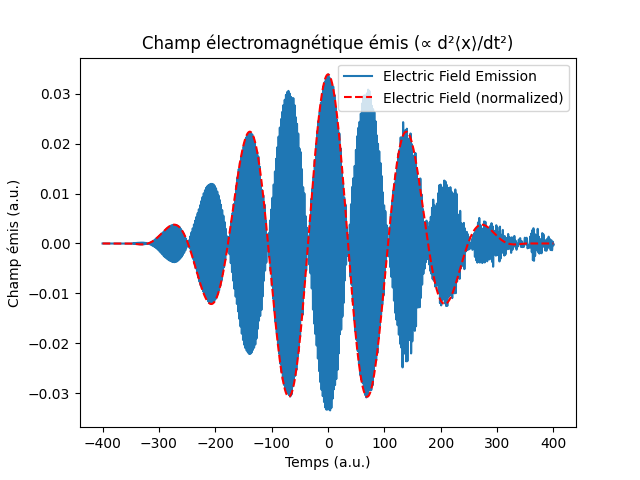

In [174]:
plt.figure()
plt.plot(t, E_emis, label='Electric Field Emission')
plt.plot(t, champE/np.max(champE)*np.max(E_emis), 'r--', label='Electric Field (normalized)')
plt.xlabel("Temps (a.u.)")
plt.ylabel("Champ émis (a.u.)")
plt.legend()
plt.title("Champ électromagnétique émis (∝ d²⟨x⟩/dt²)")

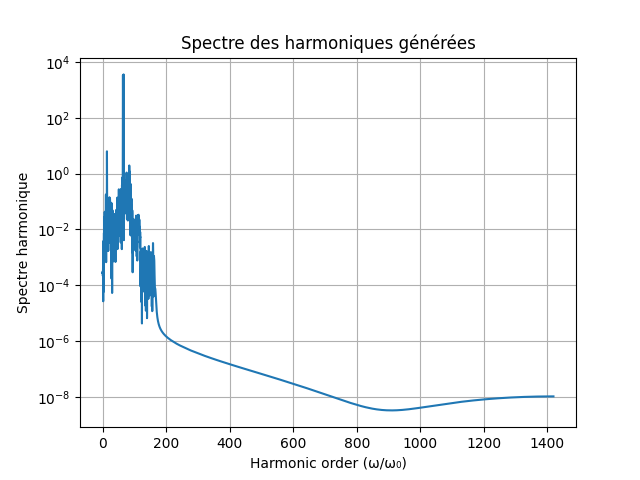

In [175]:
N = len(E_emis)
frequencies = fftfreq(N, dt)  # en a.u.^(-1)
frequencies = frequencies / t_au
# wv_plot = 3e8/frequencies
spectrum = np.abs(fft(E_emis))**2


# Affichage
plt.figure()
# plt.xscale('log')
plt.yscale('log')
plt.plot(frequencies[:N//2]/freq, spectrum[:N//2])
plt.xlabel("Harmonic order (ω/ω₀)")
plt.ylabel("Spectre harmonique")
plt.title("Spectre des harmoniques générées")
plt.grid()
